In [2]:
import tclab  # pip install tclab
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.integrate import odeint
import shutil

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


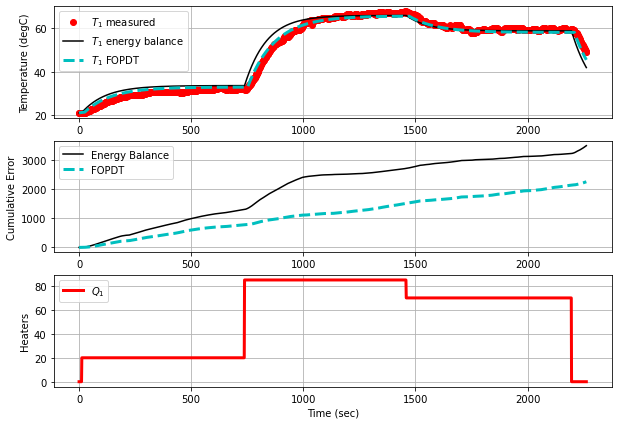

Error: Shutting down
Arduino disconnected successfully


FileNotFoundError: [Errno 2] No such file or directory: './ENGN1140_lab_1_data_2023/3_23_23data.txt'

In [3]:
# FOPDT model
Kp = 0.5      # degC/%
tauP = 120.0  # seconds
thetaP = 10   # seconds (integer)
Tss = 23      # degC (ambient temperature)
Qss = 0       # % heater

# define energy balance model
def heat(x,t,Q):
    # Parameters
    Ta = 23 + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K
    A = 12.0 / 100.0**2 # Area in m^2
    alpha = 0.01       # W / % heater
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

# save txt file
def save_txt(t,u1,y1,tp,tpl):
    data = np.vstack((t,u1,y1,tp,tpl))  # vertical stack
    data = data.T                 # transpose data
    top = 'Time (sec), Heater 1 (%),' \
        + 'Temperature 1 (degC), ' \
        + 'Energy balance (degC), FOPDT (degC)'
    np.savetxt('./ENGN1140_lab_1_data_2023/3_23_23data.txt',data,delimiter=',',header=top,comments='')


# Connect to Arduino
a = tclab.TCLab()

# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 28

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature (K)
Tsp1 = np.ones(loops) * 23.0 # set point (degC)
T1 = np.ones(loops) * a.T1 # measured T (degC)

# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q1[10:550] = 20.0 # step up for 100 sec
Q1[550:1090] = 85.0 # step up for 100 sec
Q1[1090:1630] = 70.0 # step up for 100 sec

print('Running Main Loop. Ctrl-C to end.')
print('  Time   Q1    T1')
print('{:6.1f} {:6.2f} {:6.2f}'.format(tm[0], \
                                                       Q1[0], \
                                                       T1[0]))

# Create plot
#plt.figure(figsize=(10,7))
#plt.ion()
#plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
index_iteration = 0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin
        T1[i] = a.T1

        # Simulate one time step with Energy Balance
        Tnext = odeint(heat,Tp[i-1]+273.15,[0,dt],args=(Q1[i-1],))
        Tp[i] = Tnext[1]-273.15
        error_eb[i] = error_eb[i-1] + abs(Tp[i]-T1[i])

        # Simulate one time step with FOPDT model
        z = np.exp(-dt/tauP)
        Tpl[i] = (Tpl[i-1]-Tss) * z \
                 + (Q1[max(0,i-int(thetaP)-1)]-Qss)*(1-z)*Kp \
                 + Tss
        error_fopdt[i] = error_fopdt[i-1] + abs(Tpl[i]-T1[i])

        # Write output (0-100)
        a.Q1(Q1[i])

        # Print line of data
        print('{:6.1f} {:6.2f} {:6.2f}'.format(tm[i], \
                                                               Q1[i], \
                                                               T1[i]))

        # Plot
        #plt.clf()
        fig = plt.figure(figsize=(10,7))
        ax=fig.add_subplot(3,1,1)
        ax.grid()
        ax.plot(tm[0:i],T1[0:i],'ro',label=r'$T_1$ measured')
        ax.plot(tm[0:i],Tp[0:i],'k-',label=r'$T_1$ energy balance')
        ax.plot(tm[0:i],Tpl[0:i],'c--',label=r'$T_1$ FOPDT',linewidth=3)
        ax.set_ylabel('Temperature (degC)')
        ax.legend(loc=2)
        ax=fig.add_subplot(3,1,2)
        ax.grid()
        ax.plot(tm[0:i],error_eb[0:i],'k-',label='Energy Balance')
        ax.plot(tm[0:i],error_fopdt[0:i],'c--',label='FOPDT',linewidth=3)
        ax.set_ylabel('Cumulative Error')
        ax.legend(loc='best')
        ax=fig.add_subplot(3,1,3)
        ax.grid()
        ax.plot(tm[0:i],Q1[0:i],'r-',label=r'$Q_1$',linewidth=3)
        ax.set_ylabel('Heaters')
        ax.set_xlabel('Time (sec)')
        ax.legend(loc='best')
        #plt.draw()
        #plt.pause(0.05)
        display(fig)
        
        clear_output(wait= True)
        plt.pause(0.05)
        index_iteration = i

    # Turn off heaters
    a.Q1(0)
    # Save text file
    save_txt(tm[0:index_iteration],
             Q1[0:index_iteration],
             T1[0:index_iteration],
             Tp[0:index_iteration],
             Tpl[0:index_iteration])
    # Save figure
    plt.savefig('test_Models.png')
    shutil.rmtree('__pycache__/')


# Make sure serial connection still closes when there's an error
except:
    # Disconnect from Arduino
    a.Q1(0)
    print('Error: Shutting down')
    a.close()
    save_txt(tm[0:index_iteration],
             Q1[0:index_iteration],
             T1[0:index_iteration],
             Tp[0:index_iteration],
             Tpl[0:index_iteration])
    plt.savefig('test_Models.png')
    shutil.rmtree('__pycache__/')
    raise


In [4]:
np.savetxt('./ENGN_1140_lab_1_data_2023/3_23_23data.txt',data,delimiter=',',header=top,comments='')

NameError: name 'data' is not defined

In [5]:
data

NameError: name 'data' is not defined

In [6]:
save_txt(tm[0:index_iteration],
             Q1[0:index_iteration],
             T1[0:index_iteration],
             Tp[0:index_iteration],
             Tpl[0:index_iteration])